In [1]:
pip install numpy pandas seaborn matplotlib tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import Sequential
import tensorflow as tf

In [9]:
# ImageDataGenerator is used for data augmentation and preprocessing of images.
train_datagen = ImageDataGenerator(
    featurewise_center=True,  # Subtract the mean of the dataset from each image (feature-wise).
    samplewise_center=False,  # Do not subtract the mean of each image (sample-wise).
    featurewise_std_normalization=True,  # Normalize the dataset by dividing each image by its standard deviation (feature-wise).
    samplewise_std_normalization=False,  # Do not normalize each image (sample-wise).
    zca_whitening=False,  # Do not apply ZCA whitening (used to enhance image data by reducing redundancy in pixel values).
    zca_epsilon=1e-06,  # Default epsilon value for numerical stability in ZCA whitening (not used here).
    rotation_range=0,  # No rotation augmentation (range of rotation in degrees).
    width_shift_range=0.0,  # No horizontal shift (as a fraction of total width).
    height_shift_range=0.0,  # No vertical shift (as a fraction of total height).
    brightness_range=None,  # No change in brightness.
    shear_range=0.0,  # No shearing transformation (change in the shape of the image).
    zoom_range=0.0,  # No zooming in/out.
    channel_shift_range=0.0,  # No random channel shifts (used for color augmentation).
    fill_mode='nearest',  # Points outside the boundaries of the input are filled according to the nearest pixel.
    cval=0.0,  # Constant value used for filling if fill_mode is 'constant' (not applicable here).
    horizontal_flip=False,  # Do not randomly flip the images horizontally.
    vertical_flip=False,  # Do not randomly flip the images vertically.
    rescale=1.0/255.0,  # Rescale the pixel values to be in the range [0, 1] by dividing by 255.
    preprocessing_function=None,  # No additional preprocessing function.
    data_format=None,  # Image data format (channels_last by default).
    dtype=None,  # Data type for the output images (default to float32).
    validation_split=0.2  # Reserve 20% of the data for validation.
)

# Flow images from the directory for training
train_generator = train_datagen.flow_from_directory(
    "images/Planets_Moons_Data/Planets and Moons",  # Directory where images are stored, organized by class.
    target_size=(256, 256),  # Resize all images to 256x256 pixels.
    batch_size=128,  # Number of images to be yielded from the generator per batch.
    class_mode='categorical',  # Return labels in categorical format (one-hot encoded).
    interpolation="lanczos",  # Resample the image using Lanczos interpolation for resizing.
    subset="training"  # Use this generator for training data (based on validation_split).
)

# Flow images from the directory for validation
test_generator = train_datagen.flow_from_directory(
    "images/Planets_Moons_Data/Planets and Moons",  # Same directory as the training set.
    target_size=(256, 256),  # Resize validation images to 256x256 pixels.
    batch_size=128,  # Number of images to be yielded from the generator per batch.
    class_mode='categorical',  # Return labels in categorical format (one-hot encoded).
    interpolation="lanczos",  # Resample the image using Lanczos interpolation for resizing.
    subset="validation"  # Use this generator for validation data (based on validation_split).
)

Found 1319 images belonging to 11 classes.
Found 319 images belonging to 11 classes.


In this code, the ImageDataGenerator is being used to preprocess and augment images for training and validation. The generator applies various transformations such as feature-wise centering and standard normalization, ensuring that the dataset is centered and scaled appropriately. The images are also rescaled to have pixel values between 0 and 1 by dividing by 255. Other transformations, such as random shifts, rotations, and flips, are turned off, meaning no additional augmentation beyond basic normalization is applied.

The flow_from_directory method is used to load the images directly from a directory (images/Planets_Moons_Data/Planets and Moons). It automatically organizes the data based on the folder structure, where each subfolder represents a class (e.g., planets and moons). The images are resized to 256x256 pixels and loaded in batches of 128 images. The train_generator handles the training data, while the test_generator manages the validation data, with the data split being 80% for training and 20% for validation. The images are categorized into classes using a one-hot encoded format, and Lanczos interpolation is applied to preserve image quality during resizing. This setup allows the model to train and validate on preprocessed image batches efficiently.

## Model Structuring and Coding

In [14]:
def planet_moon_model():
    # Input layer: Expects input images of shape 256x256 with 3 channels (RGB)
    inp = Input(shape=(256, 256, 3))

    # First convolutional block
    # Applies 128 filters with a 2x2 kernel, stride of 2, ReLU activation, and 'same' padding
    y = Conv2D(128, (2, 2), strides=(2, 2), padding='same', activation='ReLU', use_bias=True)(inp)
    # Normalizes the output of the convolutional layer to improve training stability
    y = BatchNormalization()(y)
    # Applies spatial dropout to randomly drop 20% of spatial features to prevent overfitting
    y = SpatialDropout2D(0.2)(y)
    # Max pooling layer reduces the spatial dimensions by taking the max value in 2x2 windows
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)

    # Second convolutional block
    # Increases the number of filters to 256 with the same settings as above
    y = Conv2D(256, (2, 2), strides=(2, 2), padding='same', activation='ReLU', use_bias=True)(y)
    # Applies spatial dropout again to reduce overfitting
    y = SpatialDropout2D(0.2)(y)
    # Another max pooling layer to further reduce spatial dimensions
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)

    # Third convolutional block
    # Increases the number of filters to 512, similar to the previous two blocks
    y = Conv2D(512, (2, 2), strides=(2, 2), padding='same', activation='ReLU', use_bias=True)(y)
    # Spatial dropout to drop 20% of spatial features
    y = SpatialDropout2D(0.2)(y)
    # Max pooling layer to reduce the size of the feature map
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)

    # Flatten the 3D output of the convolutional layers to a 1D vector for fully connected layers
    y = Flatten()(y)

    # Fully connected (dense) layer with 128 units and ReLU activation
    y = Dense(128, activation='relu')(y)

    # Output layer: 11 units (for 11 classes), using softmax activation to output probabilities
    y = Dense(11, activation='softmax')(y)

    # Create the model, specifying the input and output layers
    model = Model(inputs=inp, outputs=y)

    # Return the created model
    return model

In [15]:
def train_and_evaluate_model(name_model):
    
    # Print the name of the model being used
    print('#####~Model => {} '.format(name_model))

    # Create the model by calling the emir_model function
    model = planet_moon_model()
    
    # Print a summary of the model architecture
    model.summary()

    # Compile the model with the Adam optimizer, categorical cross-entropy loss, and accuracy metric
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Define a callback to save the model at each epoch. The model file will be saved as 'model_{epoch}.h5'.
    my_callbacks = [keras.callbacks.ModelCheckpoint("model/model_{epoch}.h5")]
    
    # Train the model using the train_generator, validate using test_generator, for 48 epochs
    # with the defined callbacks and a batch size of 128
    history = model.fit(train_generator,
                        validation_data=test_generator,
                        epochs=48,
                        callbacks=my_callbacks,
                        verbose=1,  # Verbose 1 means printing progress during training
                        batch_size=128)
    
    # Plotting accuracy and loss graphs for both training and validation
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))  # Create subplots
    ax = ax.ravel()  # Flatten the array of axes for easier iteration

    # Iterate over accuracy and loss metrics to plot their respective graphs
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])  # Plot training metric
        ax[i].plot(history.history['val_' + met])  # Plot validation metric
        ax[i].set_title('Model {}'.format(met))  # Set the title of the subplot
        ax[i].set_xlabel('epochs')  # Label x-axis as 'epochs'
        ax[i].set_ylabel(met)  # Label y-axis with the metric name
        ax[i].legend(['Train', 'Validation'])  # Add a legend for training and validation
    plt.show()  # Display the plot

    # Make predictions using the test_generator
    pred = model.predict(test_generator)
    
    # Convert predictions to the index of the highest probability class (i.e., predicted class)
    pred = np.argmax(pred, axis=1)
    
    # Retrieve the class labels from the train_generator and reverse the dictionary to map indices to labels
    labels = (train_generator.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    
    # Convert predicted indices into actual class labels
    pred = [labels[k] for k in pred]
    
    # Print the classification report header
    print('\033[01m              Classification_report \033[0m')
    
    # Print the results header
    print('\033[01m              Results \033[0m')
    
    # Evaluate the model on the test_generator and store the results (loss and accuracy)
    results = model.evaluate(test_generator, verbose=0)
    
    # Print the test loss with red formatting
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    
    # Print the test accuracy with green formatting
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    # Return the evaluation results (test loss and accuracy)
    return results

The two functions provided, train_and_evaluate_model and planet_moon_model, work together to build, train, and evaluate a convolutional neural network (CNN) for classifying images of planets and moons. The planet_moon_model function defines the architecture of the CNN, starting with an input layer for 256x256 RGB images, followed by three convolutional blocks that apply 2x2 filters with ReLU activations and spatial dropout for regularization. Each block includes batch normalization and max pooling to down-sample the feature maps. After flattening the output of the convolutional layers, a fully connected dense layer with 128 units and ReLU activation is applied, followed by an output layer with 11 units and softmax activation for multi-class classification across 11 classes.

The train_and_evaluate_model function takes a model name, initializes the model using planet_moon_model, compiles it with the Adam optimizer and categorical cross-entropy loss, and trains it using train_generator and test_generator datasets. It also uses a callback to save the model at each epoch. After training for 48 epochs, the function plots the accuracy and loss for both training and validation, evaluates the model on the test set, and prints the test loss and accuracy. It also makes predictions on the test set and returns the final evaluation results. Together, these two functions are used to train a CNN for image classification and evaluate its performance.

### Prepping Models and providing Benchmark Scores

#####~Model => Planets_Moon_Detection_Using_Artificial_Intelligence_2 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     1664      
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 spatial_dropout2d_6 (Spatia  (None, 128, 128, 128)    0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                    

/opt/anaconda3/envs/localsm/lib/python3.9/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/anaconda3/envs/localsm/lib/python3.9/site-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
2024-10-10 14:40:01.230614: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - 13s 1s/step - loss: 2.0531 - accuracy: 0.3434 - val_loss: 2.2443 - val_accuracy: 0.4389
Epoch 2/48
11/11 [==============================] - 14s 1s/step - loss: 1.0152 - accuracy: 0.6497 - val_loss: 1.9499 - val_accuracy: 0.2790
Epoch 3/48
11/11 [==============================] - 12s 1s/step - loss: 0.5528 - accuracy: 0.7695 - val_loss: 1.8369 - val_accuracy: 0.3041
Epoch 4/48
11/11 [==============================] - 12s 1s/step - loss: 0.3285 - accuracy: 0.8650 - val_loss: 1.8295 - val_accuracy: 0.3386
Epoch 5/48
11/11 [==============================] - 12s 1s/step - loss: 0.2785 - accuracy: 0.9037 - val_loss: 1.7530 - val_accuracy: 0.5580
Epoch 6/48
11/11 [==============================] - 12s 1s/step - loss: 0.1741 - accuracy: 0.9469 - val_loss: 1.6491 - val_accuracy: 0.6677
Epoch 7/48
11/11 [==============================] - 13s 1s/step - loss: 0.1246 - accuracy: 0.9568 - val_loss: 1.4734 - val_accuracy: 0.7900
Epoch 8/48
11/11 [=============

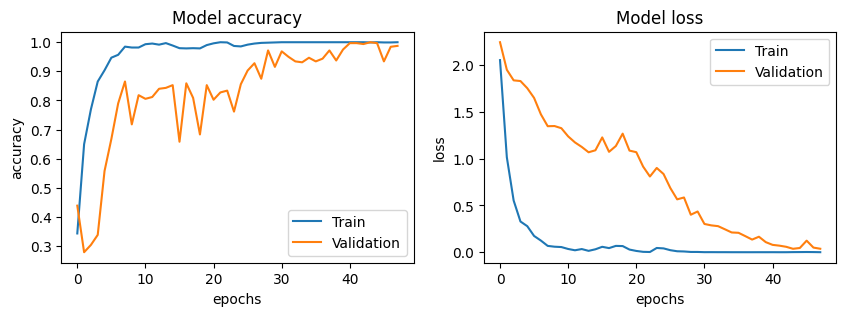

3/3 [==============================] - 1s 188ms/step
              Classification_report 
              Results 
    Test Loss:  0.03737  
Test Accuracy:  98.75%  


In [17]:
model_name = "Planets_Moon_Detection_Using_Artificial_Intelligence_2"
result_model = train_and_evaluate_model(model_name)

In [26]:
## Predicting for Earth
prediction_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1.0/255.0,
    preprocessing_function=None,
    data_format=None, 
    dtype=None)
prediction_generator = prediction_datagen.flow_from_directory("images/Test_Earth",target_size=(256, 256),
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    interpolation="lanczos")

Found 1 images belonging to 1 classes.


### Loading Model by Adil

In [19]:
from tensorflow.keras.models import load_model

model = load_model("model/model_48.h5")

## Preiction Algorithm

In [29]:
def prediction(model, data):
    # Get the model's predictions for the input data (this will return an array of probabilities for each class)
    prediction = model.predict(data)

    # The prediction is a list of probabilities for each class. We find the maximum probability (the most confident prediction).
    # prediction[0] refers to the first sample's prediction (assuming you're predicting for one image at a time).

    # Check which class has the highest probability, and based on that, print the corresponding planet or moon.
    
    if prediction[0].max() == prediction[0][0]:
        # If the highest probability is for index 0, predict 'Earth'
        print("Planet Prediction is 'Earth'! ")
    
    elif prediction[0].max() == prediction[0][1]:
        # If the highest probability is for index 1, predict 'Jupiter'
        print("Planet Prediction is 'Jupiter'! ")
    
    elif prediction[0].max() == prediction[0][2]:
        # If the highest probability is for index 2, predict 'Makemake' (dwarf planet)
        print("Dwarf Planet Prediction is 'Makemake'! ")
    
    elif prediction[0].max() == prediction[0][3]:
        # If the highest probability is for index 3, predict 'Mars'
        print("Planet Prediction is 'Mars'! ")
    
    elif prediction[0].max() == prediction[0][4]:
        # If the highest probability is for index 4, predict 'Mercury'
        print("Planet Prediction is 'Mercury'! ")
    
    elif prediction[0].max() == prediction[0][5]:
        # If the highest probability is for index 5, predict 'Moon'
        print("Moon Prediction is 'Moon'! ")
    
    elif prediction[0].max() == prediction[0][6]:
        # If the highest probability is for index 6, predict 'Neptune'
        print("Planet Prediction is 'Neptune'! ")
    
    elif prediction[0].max() == prediction[0][7]:
        # If the highest probability is for index 7, predict 'Pluto' (dwarf planet)
        print("Dwarf Planet Prediction is 'Pluto'! ")
    
    elif prediction[0].max() == prediction[0][8]:
        # If the highest probability is for index 8, predict 'Saturn'
        print("Planet Prediction is 'Saturn'! ")
    
    elif prediction[0].max() == prediction[0][9]:
        # If the highest probability is for index 9, predict 'Uranus'
        print("Planet Prediction is 'Uranus'! ")
    
    elif prediction[0].max() == prediction[0][10]:
        # If the highest probability is for index 10, predict 'Venus'
        print("Planet Prediction is 'Venus'! ")

In [21]:
prediction(model,prediction_generator)

1/1 [==============================] - 0s 80ms/step
Planet Prediction is 'Earth'! 


In [27]:
## Predicting for Mars
prediction_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1.0/255.0,
    preprocessing_function=None,
    data_format=None, 
    dtype=None)
prediction_generator = prediction_datagen.flow_from_directory("images/Test_Mars",target_size=(256, 256),
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    interpolation="lanczos")

Found 1 images belonging to 1 classes.


In [23]:
prediction(model,prediction_generator)

1/1 [==============================] - 0s 62ms/step
Planet Prediction is 'Mars'! 


In [30]:
## Predicting for Jupiter
prediction_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1.0/255.0,
    preprocessing_function=None,
    data_format=None, 
    dtype=None)
prediction_generator = prediction_datagen.flow_from_directory("images/Test_Jupiter",target_size=(256, 256),
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    interpolation="lanczos")

Found 1 images belonging to 1 classes.


In [31]:
prediction(model,prediction_generator)

1/1 [==============================] - 0s 43ms/step
Planet Prediction is 'Jupiter'! 
